In [7]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall


# === IMAGE PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32

In [8]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


# Data Preprocessing

In [9]:
dataset_path = "dataset/input"
output_dir = "dataset/split_dataset"
os.makedirs(output_dir, exist_ok=True)

all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split the dataset into training (60%), validation (20%), and test sets (20%)
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

test_labels = test_df["label"].values
unique_labels = set(test_labels)

print(f"Total images: {len(df)}")
print(f"Unique Labels: {unique_labels})")


print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Total images: 15000
Unique Labels: {'adenocarcinoma', 'benign', 'squamous_cell_carcinoma'})
Training set size: 9000
Validation set size: 3000
Test set size: 3000


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


Image shape: (32, 224, 224, 3)


<Figure size 640x480 with 0 Axes>

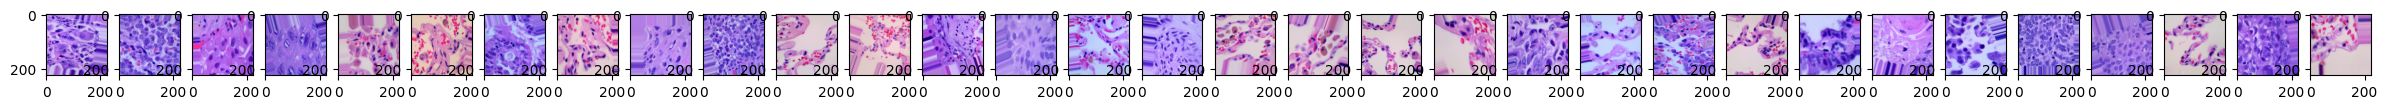

In [11]:
images, labels = train_generator[0]
print(f"Image shape: {images.shape}")

plt.figure()

# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))


for i in range(images.shape[0]):
    axarr[i].imshow(images[i])

In [12]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(train_generator.class_indices)
METRICS = metrics = ["accuracy", Precision(name="precision"), Recall(name="recall")]
EPOCHS = 10

# Model architecture implementation
model = Sequential()
model.add(
    Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation="relu", input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Flatten())
model.add(Dense(FULLY_CONNECT_NUM, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(learning_rate=2e-5),
    metrics=["acc"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [13]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
)

acc = history.history["acc"]
loss = history.history["loss"]

Epoch 1/10
282/282 [==============================] - 139s 446ms/step - loss: 0.5169 - acc: 0.7602 - val_loss: 0.3990 - val_acc: 0.8277
Epoch 2/10
282/282 [==============================] - 85s 302ms/step - loss: 0.3814 - acc: 0.8254 - val_loss: 0.4070 - val_acc: 0.8270
Epoch 3/10
282/282 [==============================] - 78s 275ms/step - loss: 0.3506 - acc: 0.8478 - val_loss: 0.3218 - val_acc: 0.8570
Epoch 4/10
282/282 [==============================] - 83s 295ms/step - loss: 0.3257 - acc: 0.8613 - val_loss: 0.3298 - val_acc: 0.8567
Epoch 5/10
282/282 [==============================] - 80s 282ms/step - loss: 0.3075 - acc: 0.8651 - val_loss: 0.2867 - val_acc: 0.8653
Epoch 6/10
282/282 [==============================] - 79s 281ms/step - loss: 0.2936 - acc: 0.8758 - val_loss: 0.2893 - val_acc: 0.8690
Epoch 7/10
282/282 [==============================] - 79s 280ms/step - loss: 0.2814 - acc: 0.8804 - val_loss: 0.2571 - val_acc: 0.8933
Epoch 8/10
282/282 [==============================] - 

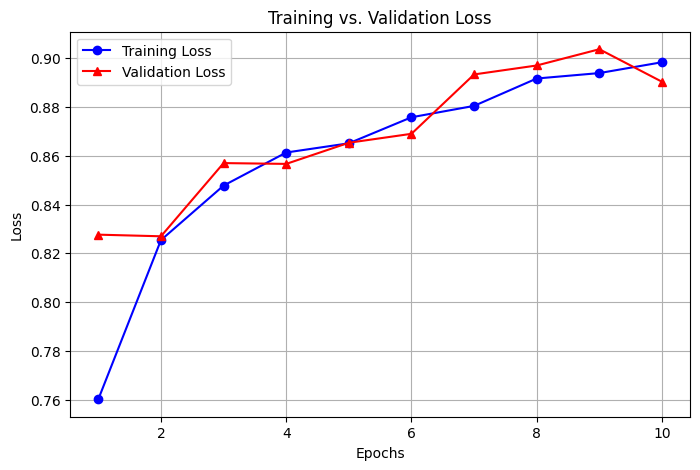

In [14]:
# Run this cell to load the model history into a pandas DataFrame

# frame = pd.DataFrame(history.history)

# acc_plot = frame.plot(y="acc", title="Accuracy vs Epochs", legend=False)
# acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

# Extract loss values
train_loss = history.history["acc"]
val_loss = history.history["val_acc"]
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    epochs, train_loss, "bo-", label="Training Loss"
)  # 'bo-' = blue circles with a solid line
plt.plot(
    epochs, val_loss, "r^-", label="Validation Loss"
)  # 'r^-' = red triangles with a solid line
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()
plt.show()

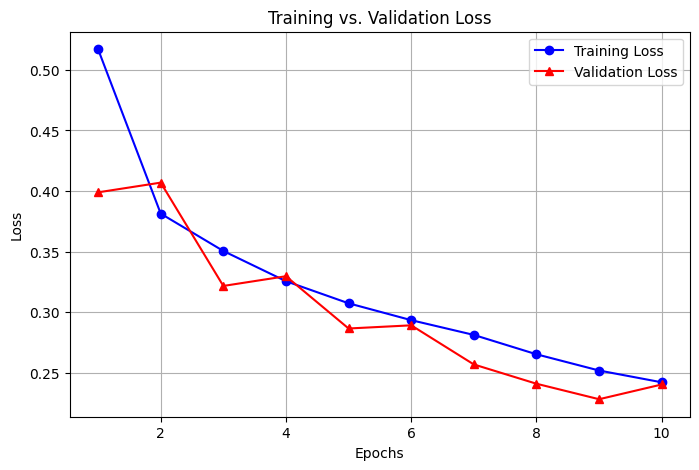

In [15]:
# acc_plot = frame.plot(y="loss", title="Loss vs Epochs", legend=False)
# acc_plot.set(xlabel="Epochs", ylabel="Loss")
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    epochs, train_loss, "bo-", label="Training Loss"
)  # 'bo-' = blue circles with a solid line
plt.plot(
    epochs, val_loss, "r^-", label="Validation Loss"
)  # 'r^-' = red triangles with a solid line
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [16]:
# Predictions
predictions = model.predict(test_generator)

# Model evaluation
loss, accuracy = model.evaluate(test_generator, steps=25)
print("\ntest acc :\n", accuracy)

25/25 [==============================] - 3s 99ms/step - loss: 0.2117 - acc: 0.8950

test acc :
 0.8949999809265137


94/94 [==============================] - 10s 102ms/step
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1000
           1       0.98      0.96      0.97      1000
           2       0.82      0.96      0.89      1000

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



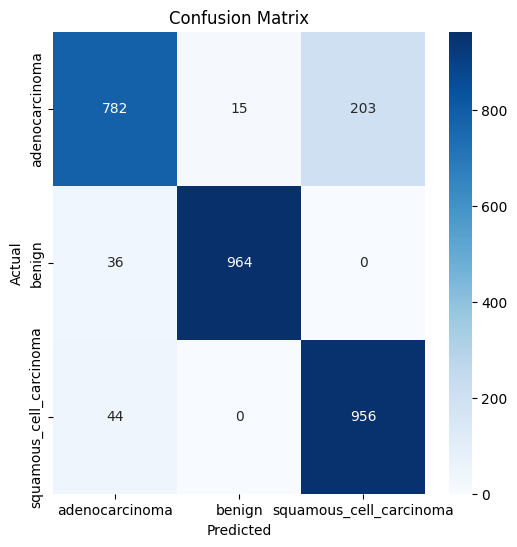

In [18]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate Model
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_val = test_generator.classes
print(classification_report(y_val, y_pred))

#  Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_val, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()